# Final Project

## Signature Verification
## Nida Ulhaq Fitriyah

In [1]:
#!pip install opencv-python

In [2]:
#!pip install pandarallel

In [3]:
#!pip install tensorflow

In [4]:
import multiprocessing

num_processors = multiprocessing.cpu_count()
num_processors

16

In [5]:
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=num_processors-1, use_memory_fs=False)

workers=num_processors

INFO: Pandarallel will run on 15 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import glob
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import applications
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import backend as K
import gc
from tensorflow.keras import layers, models
import pickle
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

2023-05-24 13:44:46.990401: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-24 13:44:47.053337: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-24 13:44:47.054512: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-24 13:44:48.159227: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [7]:
from tqdm import tqdm

In [8]:
import io
from google.cloud import storage

## Data Preprocessing

In [9]:
#Import metadata for train and test
train_df = pd.read_csv('train_data.csv')
#train_df = train_df.drop('0', axis=1)
train_df = train_df.rename(columns={'0':'Image1','1': 'Image2', '2': 'Label'})

print(train_df.shape)
train_df.head()

(76721, 3)


,Image1,Image2,Label
0,100/100_22.png,100/100_20.png,1
1,078/078_17.png,078/078_13.png,1
2,089/089_17.png,089_forg/089_forg_18.png,0
3,111/111_15.png,111/111_03.png,1
4,092/092_10.png,092_forg/092_forg_05.png,0


In [10]:
test_df = pd.read_csv('test_data.csv')
#test_df = test_df.drop('0', axis=1)
test_df = test_df.rename(columns={'0':'Image1','1': 'Image2', '2': 'Label'})

print(test_df.shape)
test_df.head()

(8525, 3)


,Image1,Image2,Label
0,099/099_14.png,099_forg/099_forg_09.png,0
1,002/002_18.png,002/002_11.png,1
2,039/039_05.png,039_forg/039_forg_00.png,0
3,112/112_23.png,112_forg/112_forg_06.png,0
4,116/116_21.png,116_forg/116_forg_06.png,0


In [49]:
# Create a client to interact with your Google Bucket
client = storage.Client()

# Define your Google Bucket name
bucket_name = 'final-project-mlpa'

# Define the batch size and image dimensions
batch_size = 32
image_size = (224, 224)

class ImageDataGenerator(Sequence):
    def __init__(self, dataframe, batch_size=batch_size, shuffle=True):
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataframe))
        self.image_sizes = []  # List to collect image sizes
        
    def __len__(self):
        return int(np.ceil(len(self.dataframe) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        batch_df = self.dataframe.iloc[batch_indexes]
        
        images = []
        labels = []
        
        for _, row in batch_df.iterrows():
            image_path = row['Image2']
            label = row['Label']
            
            blob2 = client.bucket(bucket_name).blob('full/' + image_path)
            img_bytes2 = blob2.download_as_bytes()
            img2 = Image.open(io.BytesIO(img_bytes2)).convert('RGB')
            img2 = img2.resize(image_size)
            img2 = np.array(img2) / 255.0
            
            #combined_images = np.concatenate([img1, img2], axis=2)  # Combine Image1 and Image2
            images.append(img2)
            labels.append(label)
            
        images = np.array(images)
        self.image_sizes.extend([(image.shape[0], image.shape[1]) for image in images])
        
        return np.array(images), np.array(labels)


In [50]:
#Create validation dataset from train_df
new_train_df, validation_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Create an instance of the data generator
train_data_generator = ImageDataGenerator(new_train_df,batch_size=batch_size)
validation_data_generator = ImageDataGenerator(validation_df,batch_size=batch_size)
test_data_generator = ImageDataGenerator(test_df,batch_size=batch_size)

## EDA

1    38666
0    38055
Name: Label, dtype: int64


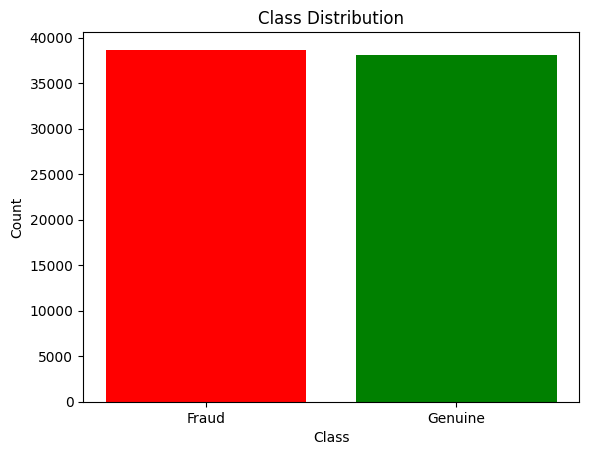

In [40]:
#Check for class balance train data

#combined_df = pd.concat([train_df, test_df], ignore_index=True)
class_counts = train_df['Label'].value_counts()
labels = ['Fraud', 'Genuine']
colors = ['red', 'green']

print(class_counts)

plt.bar(labels, class_counts, color=colors)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

1    4296
0    4229
Name: Label, dtype: int64


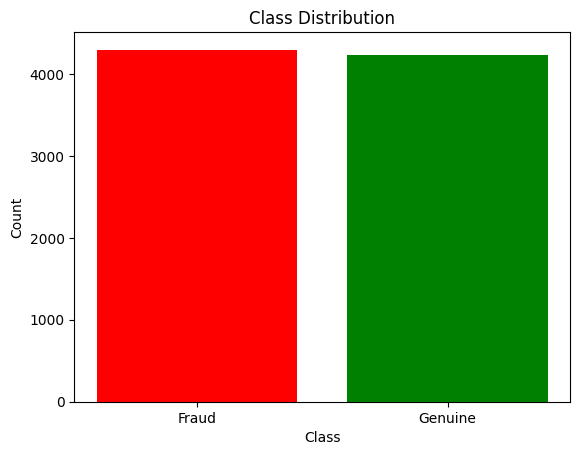

In [41]:
#Check for class balance test data

#combined_df = pd.concat([train_df, test_df], ignore_index=True)
class_counts = test_df['Label'].value_counts()
labels = ['Fraud', 'Genuine']
colors = ['red', 'green']

print(class_counts)

plt.bar(labels, class_counts, color=colors)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

1    42962
0    42284
Name: Label, dtype: int64


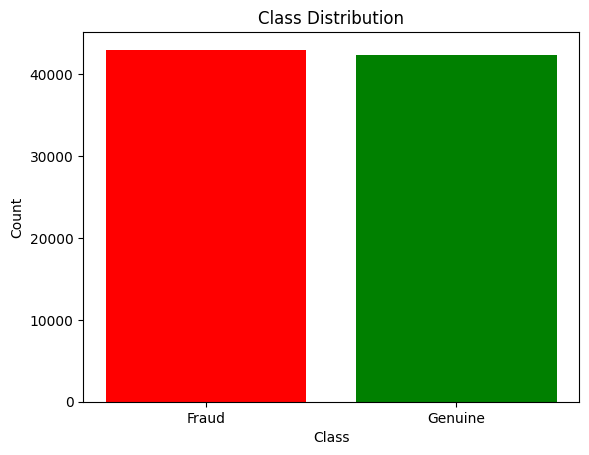

In [42]:
#Check for class balance combined train and tes

combined_df = pd.concat([train_df, test_df], ignore_index=True)
class_counts = combined_df['Label'].value_counts()
labels = ['Fraud', 'Genuine']
colors = ['red', 'green']

print(class_counts)

plt.bar(labels, class_counts, color=colors)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

<b> Check the size distribution of images data </b>

In [52]:
def load_and_preprocess_images(image_paths, image_size):
    images = []
    for image_path in image_paths:
        blob = client.bucket(bucket_name).blob('full/' + image_path)
        img_bytes = blob.download_as_bytes()
        img = Image.open(io.BytesIO(img_bytes)).convert('RGB')
        img = img.resize(image_size)
        img = np.array(img) / 255.0
        images.append(img)
    return np.array(images)

In [55]:
test_image_paths = test_df['Image2'].values
test_images = load_and_preprocess_images(test_image_paths, image_size)

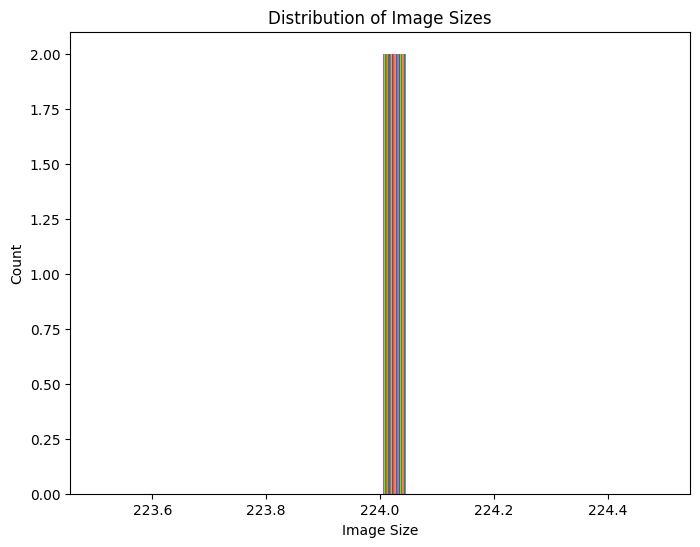

In [56]:
# Plot the size distribution
image_dimensions = [(img.shape[0], img.shape[1]) for img in test_images]

plt.figure(figsize=(8, 6))
plt.hist(image_dimensions, bins=20)  # Plot the distribution of image sizes
plt.xlabel('Image Size')
plt.ylabel('Count')
plt.title('Distribution of Image Sizes')
plt.show()

## Feature Extraction and Classification

<b> Basic initial model </b>

In [16]:
# Define the input layer for image1
input = layers.Input(shape=(224, 224, 3))

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.001),metrics=['accuracy'])

# Print the model summary
model.summary()

# Define the number of epochs and batch size
epochs = 10
batch_size = 32

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model using the data generator
history = model.fit(
    train_data_generator,
    steps_per_epoch=len(train_data_generator) // batch_size,
    epochs=epochs,
    validation_data=validation_data_generator,
    validation_steps=len(validation_data_generator) // batch_size,
    callbacks=[early_stopping]
)

# Get the validation data for evaluation
val_inputs, val_labels = validation_data_generator[0]
val_images = val_inputs

# Evaluate the model on the validation data
val_loss, val_acc = model.evaluate(val_images, val_labels)

# Get the test data for evaluation
test_inputs, test_labels = test_data_generator[0]
test_images = test_inputs

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_images, test_labels)

# Print the validation and test metrics
print('Validation accuracy:', val_acc)
print('Validation loss:', val_loss)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

model.save('feature_extraction_model_1.h5')


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 26, 26, 128)     

2023-05-24 13:50:12.598122: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


59/59 [==============================] - ETA: 0s - loss: 0.8737 - accuracy: 0.5106

2023-05-24 13:51:39.112162: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


59/59 [==============================] - 106s 2s/step - loss: 0.8737 - accuracy: 0.5106 - val_loss: 0.6844 - val_accuracy: 0.6583
Epoch 2/10
59/59 [==============================] - 101s 2s/step - loss: 0.6687 - accuracy: 0.6102 - val_loss: 0.6739 - val_accuracy: 0.5583
Epoch 3/10
59/59 [==============================] - 99s 2s/step - loss: 0.6361 - accuracy: 0.6234 - val_loss: 0.6337 - val_accuracy: 0.6208
Epoch 4/10
59/59 [==============================] - 101s 2s/step - loss: 0.5425 - accuracy: 0.7325 - val_loss: 0.4615 - val_accuracy: 0.7812
Epoch 5/10
59/59 [==============================] - 95s 2s/step - loss: 0.4938 - accuracy: 0.7590 - val_loss: 0.3925 - val_accuracy: 0.8438
Epoch 6/10
59/59 [==============================] - 96s 2s/step - loss: 0.4089 - accuracy: 0.8099 - val_loss: 0.2921 - val_accuracy: 0.8667
Epoch 7/10
59/59 [==============================] - 96s 2s/step - loss: 0.3516 - accuracy: 0.8443 - val_loss: 0.4723 - val_accuracy: 0.8000
Epoch 8/10
59/59 [==========

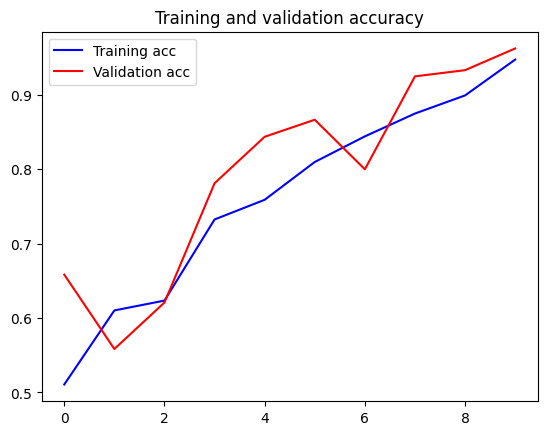

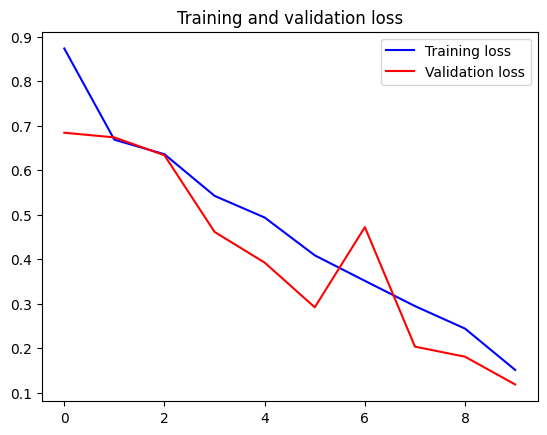

In [17]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], 'b', label='Training acc')
plt.plot(history.history['val_accuracy'], 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'], 'b', label='Training loss')
plt.plot(history.history['val_loss'], 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

<b> Using pre-trained model VGG16 </b>

In [22]:
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model_2 = models.Sequential()
model_2.add(base_model)
model_2.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model_2.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model_2.add(layers.Flatten())
model_2.add(layers.Dense(512, activation='relu'))
model_2.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model_2.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_2.summary()

# Define the number of epochs and batch size
epochs = 10
batch_size = 32

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_2 = model_2.fit(
    train_data_generator,
    steps_per_epoch=len(train_data_generator) // batch_size,
    epochs=epochs,
    validation_data=validation_data_generator,
    validation_steps=len(validation_data_generator) // batch_size,
    callbacks=[early_stopping]
)




Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d_16 (Conv2D)          (None, 7, 7, 32)          147488    
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 3, 3, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 3, 3, 64)          18496     
                                                                 
 conv2d_18 (Conv2D)          (None, 3, 3, 128)         73856     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 1, 1, 128)        0         
 g2D)                                                 

2023-05-24 14:37:06.129460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


59/59 [==============================] - ETA: 0s - loss: 0.7500 - accuracy: 0.5079

2023-05-24 14:45:48.551920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


59/59 [==============================] - 555s 9s/step - loss: 0.7500 - accuracy: 0.5079 - val_loss: 0.6993 - val_accuracy: 0.4417
Epoch 2/10
59/59 [==============================] - 540s 9s/step - loss: 0.6942 - accuracy: 0.5074 - val_loss: 0.6948 - val_accuracy: 0.4417
Epoch 3/10
59/59 [==============================] - 536s 9s/step - loss: 0.6970 - accuracy: 0.4873 - val_loss: 0.6932 - val_accuracy: 0.4417
Epoch 4/10
59/59 [==============================] - 536s 9s/step - loss: 0.6936 - accuracy: 0.5032 - val_loss: 0.6923 - val_accuracy: 0.5583
Epoch 5/10
59/59 [==============================] - 538s 9s/step - loss: 0.6933 - accuracy: 0.4793 - val_loss: 0.6930 - val_accuracy: 0.5583
Epoch 6/10
59/59 [==============================] - 537s 9s/step - loss: 0.6932 - accuracy: 0.4905 - val_loss: 0.6934 - val_accuracy: 0.4417
Epoch 7/10
59/59 [==============================] - 537s 9s/step - loss: 0.6932 - accuracy: 0.4915 - val_loss: 0.6928 - val_accuracy: 0.5583


NameError: name 'val_images1' is not defined

In [23]:
val_loss, val_acc = model_2.evaluate(val_images, val_labels)
test_loss, test_acc = model_2.evaluate(test_images, test_labels)

print('Validation accuracy:', val_acc)
print('Validation loss:', val_loss)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

model_2.save('feature_extraction_model_2.h5')

1/1 [==============================] - 2s 2s/step - loss: 0.6913 - accuracy: 0.6250
Validation accuracy: 0.59375
Validation loss: 0.6917963624000549
Test accuracy: 0.625
Test loss: 0.6913371086120605


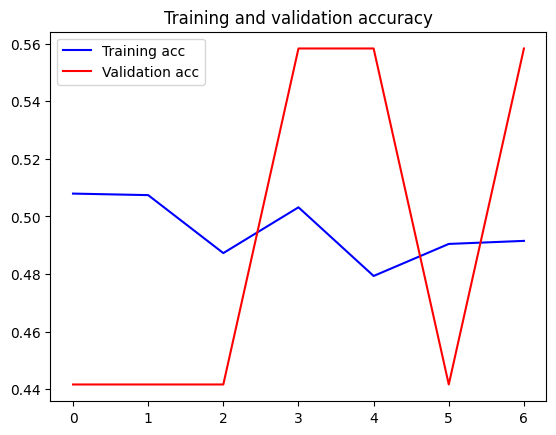

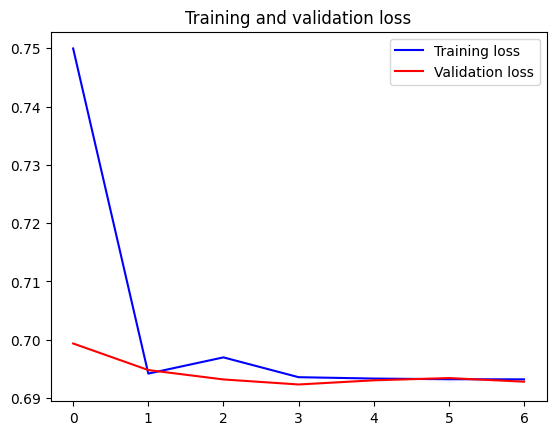

In [24]:
# Plot the training and validation accuracy
plt.plot(history_2.history['accuracy'], 'b', label='Training acc')
plt.plot(history_2.history['val_accuracy'], 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss
plt.plot(history_2.history['loss'], 'b', label='Training loss')
plt.plot(history_2.history['val_loss'], 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

<b> Using pre-trained model Inception_v3 </b>

In [26]:
base_model = applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model_3 = models.Sequential()
model_3.add(base_model)
model_3.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
model_3.add(layers.MaxPooling2D((2, 2)))
model_3.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model_3.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model_3.add(layers.MaxPooling2D((2, 2)))
model_3.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model_3.add(layers.Flatten())
model_3.add(layers.Dense(512, activation='relu'))
model_3.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model_3.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_3.summary()

# Define the number of epochs and batch size
epochs = 10
batch_size = 32

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_3 = model_3.fit(
    train_data_generator,
    steps_per_epoch=len(train_data_generator) // batch_size,
    epochs=epochs,
    validation_data=validation_data_generator,
    validation_steps=len(validation_data_generator) // batch_size,
    callbacks=[early_stopping]
)

val_loss, val_acc = model_3.evaluate(val_images, val_labels)
test_loss, test_acc = model_3.evaluate(test_images, test_labels)

print('Validation accuracy:', val_acc)
print('Validation loss:', val_loss)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

model_3.save('feature_extraction_model_3.h5')


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 conv2d_114 (Conv2D)         (None, 5, 5, 32)          589856    
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 2, 2, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_115 (Conv2D)         (None, 2, 2, 64)          18496     
                                                                 
 conv2d_116 (Conv2D)         (None, 2, 2, 128)         73856     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 1, 1, 128)        0         
 g2D)                                                 

2023-05-24 16:24:59.226779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


59/59 [==============================] - ETA: 0s - loss: 0.3133 - accuracy: 0.8771

2023-05-24 16:27:35.730787: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


59/59 [==============================] - 180s 3s/step - loss: 0.3133 - accuracy: 0.8771 - val_loss: 738.7357 - val_accuracy: 0.4417
Epoch 2/10
59/59 [==============================] - 153s 3s/step - loss: 0.1156 - accuracy: 0.9629 - val_loss: 41.2535 - val_accuracy: 0.5583
Epoch 3/10
59/59 [==============================] - 154s 3s/step - loss: 0.1169 - accuracy: 0.9730 - val_loss: 8.9076 - val_accuracy: 0.4187
Epoch 4/10
59/59 [==============================] - 152s 3s/step - loss: 0.1383 - accuracy: 0.9566 - val_loss: 80.2739 - val_accuracy: 0.4417
Epoch 5/10
59/59 [==============================] - 171s 3s/step - loss: 0.1142 - accuracy: 0.9672 - val_loss: 377.8282 - val_accuracy: 0.5625
Epoch 6/10
59/59 [==============================] - 167s 3s/step - loss: 0.0697 - accuracy: 0.9820 - val_loss: 4.9370 - val_accuracy: 0.5604
Epoch 7/10
59/59 [==============================] - 159s 3s/step - loss: 0.0484 - accuracy: 0.9857 - val_loss: 4.6163 - val_accuracy: 0.5771
Epoch 8/10
59/59 [

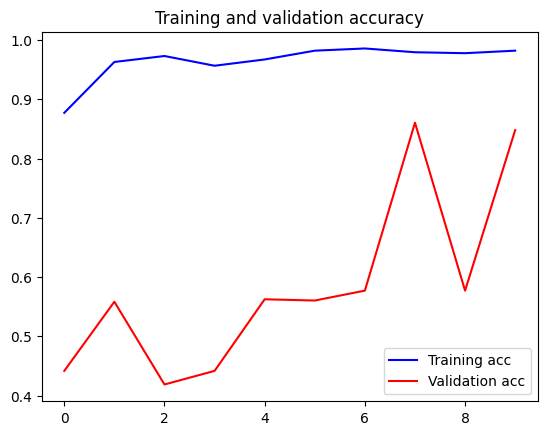

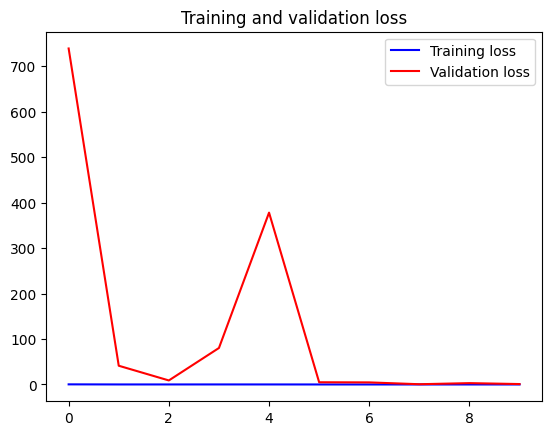

In [27]:
# Plot the training and validation accuracy
plt.plot(history_3.history['accuracy'], 'b', label='Training acc')
plt.plot(history_3.history['val_accuracy'], 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss
plt.plot(history_3.history['loss'], 'b', label='Training loss')
plt.plot(history_3.history['val_loss'], 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

<b> Using pre-trained model ResNet50 </b>

In [31]:
base_model = applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model_4 = models.Sequential()
model_4.add(base_model)
model_4.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
model_4.add(layers.MaxPooling2D((2, 2)))
model_4.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model_4.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model_4.add(layers.MaxPooling2D((2, 2)))
model_4.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model_4.add(layers.Flatten())
model_4.add(layers.Dense(512, activation='relu'))
model_4.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model_4.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_4.summary()

# Define the number of epochs and batch size
epochs = 10
batch_size = 32

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_4 = model_4.fit(
    train_data_generator,
    steps_per_epoch=len(train_data_generator) // batch_size,
    epochs=epochs,
    validation_data=validation_data_generator,
    validation_steps=len(validation_data_generator) // batch_size,
    callbacks=[early_stopping]
)

val_loss, val_acc = model_4.evaluate(val_images, val_labels)
test_loss, test_acc = model_4.evaluate(test_images, test_labels)

print('Validation accuracy:', val_acc)
print('Validation loss:', val_loss)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

model_4.save('feature_extraction_model_4.h5')

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 conv2d_122 (Conv2D)         (None, 7, 7, 32)          589856    
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 3, 3, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_123 (Conv2D)         (None, 3, 3, 64)          18496     
                                                                 
 conv2d_124 (Conv2D)         (None, 3, 3, 128)         73856     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 1, 1, 128)        0         
 g2D)                                                 

2023-05-24 17:33:31.356670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


59/59 [==============================] - ETA: 0s - loss: 0.2687 - accuracy: 0.9100

2023-05-24 17:37:05.864768: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


59/59 [==============================] - 236s 4s/step - loss: 0.2687 - accuracy: 0.9100 - val_loss: 701.6472 - val_accuracy: 0.4417
Epoch 2/10
59/59 [==============================] - 220s 4s/step - loss: 0.1165 - accuracy: 0.9608 - val_loss: 0.7132 - val_accuracy: 0.4417
Epoch 3/10
59/59 [==============================] - 213s 4s/step - loss: 0.0915 - accuracy: 0.9709 - val_loss: 238.1022 - val_accuracy: 0.4417
Epoch 4/10
59/59 [==============================] - 215s 4s/step - loss: 0.1369 - accuracy: 0.9693 - val_loss: 1.1130 - val_accuracy: 0.4417
Epoch 5/10
1/1 [==============================] - 1s 677ms/step - loss: 0.7285 - accuracy: 0.3750
Validation accuracy: 0.40625
Validation loss: 0.7213136553764343
Test accuracy: 0.375
Test loss: 0.7285023927688599


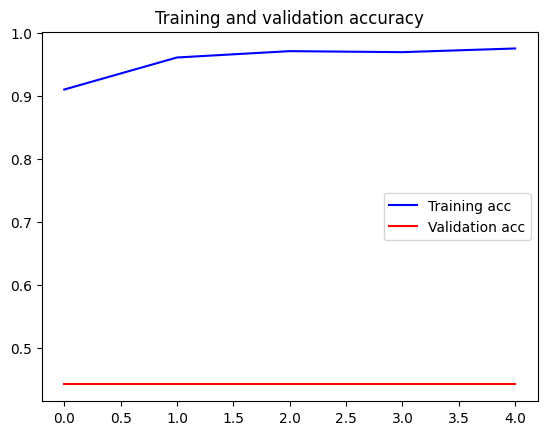

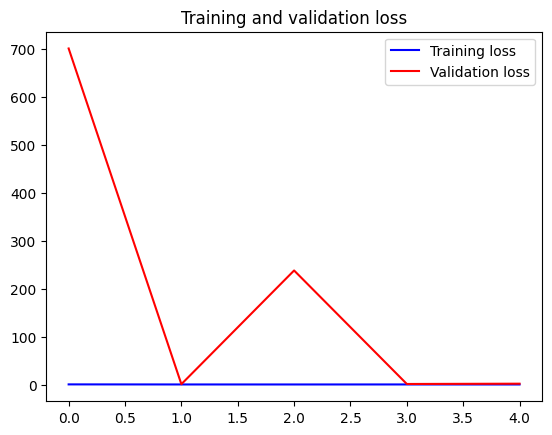

In [ ]:
# Plot the training and validation accuracy
plt.plot(history_4.history['accuracy'], 'b', label='Training acc')
plt.plot(history_4.history['val_accuracy'], 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss
plt.plot(history_4.history['loss'], 'b', label='Training loss')
plt.plot(history_4.history['val_loss'], 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Model_2, Model_3, and Model_4 (Pre-trained models) show obvious sign of overfitting and underfitting. Thus, we continue with our initial model.

## Prediction

In [34]:
#Load the selected feature extraction model
from keras.models import load_model

selected_model = load_model('feature_extraction_model_1.h5')

In [35]:
# Make predictions on the test data
predictions = selected_model.predict(test_data_generator)

# Get the predicted class labels
predicted_labels = np.argmax(predictions, axis=1)

2023-05-24 17:57:15.729126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


267/267 [==============================] - 311s 1s/step


AttributeError: 'ImageDataGenerator' object has no attribute 'labels'

In [36]:
true_labels = []
for i in range(len(test_data_generator)):
    _, batch_labels = test_data_generator[i]
    true_labels.extend(batch_labels)

# Convert the true labels to a numpy array
true_labels = np.array(true_labels)

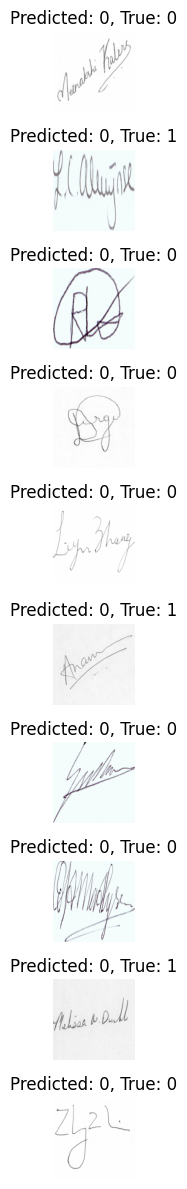

In [37]:
# Print and visualize example predictions
num_examples = 10  # Number of examples to display
fig, axes = plt.subplots(nrows=num_examples, ncols=1, figsize=(8, 12))

for i in range(num_examples):
    image = test_images[i]
    predicted_label = predicted_labels[i]
    true_label = true_labels[i]

    # Display the image
    axes[i].imshow(image)
    axes[i].axis('off')

    # Set the title with predicted and true labels
    axes[i].set_title(f"Predicted: {predicted_label}, True: {true_label}")

plt.tight_layout()
plt.show()